In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import sys,os

from scipy.stats import zscore

from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [2]:
# %%capture
# # import case-control numbers for diseases
# sys.path.insert(0, '/SSD/home/michael/retina-phenotypes/complementary/N_cases_diseases_per_Ventile/')
# import ratio_diseases_QC as r
# df1,df2 = r.quantile_specific_N_diseases(2)

In [3]:
# Paths

RUN_PATH = "/NVME/decrypted/scratch/multitrait/UK_BIOBANK_PREPRINT/"
PHENO_PATH = RUN_PATH+"participant_phenotype/"
ID = "2022_11_23_covar_fix"
SUPPLEMENTARY_LABELS='tau1_all,tau1_artery,tau1_vein,ratio_AV_DF,tau2_all,tau2_artery,tau2_vein,tau4_all,tau4_artery,tau4_vein,D_std,D_A_std,D_V_std,D_CVMe,D_CVMe_A,D_CVMe_V,bifurcations,VD_orig_all,VD_orig_artery,VD_orig_vein,ratio_VD,FD_all,FD_artery,FD_vein,mean_angle_taa,mean_angle_tva,eq_CRAE,eq_CRVE,CRAE,CRVE,ratio_CRAE_CRVE,ratio_standard_CRE,medianDiameter_all,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter'.split(',')
SUPPLEMENTARY_NAMES='tortuosity,A tortuosity,V tortuosity,ratio tortuosity,tortuosity2,A tortuosity2,V tortuosity2,tortuosity3,A tortuosity3,V tortuosity3,std diameter,A std diameter,V std diameter,CVMe diameter,A CVMe diameter,V CVMe diameter,bifurcations,vascular density,A vascular density,V vascular density,ratio vascular density,fractal dimension,A fractal dimension,V fractal dimension,A temporal angle,V temporal angle,A central retinal eq,V central retinal eq,A central retinal eq2,V central retinal eq2,ratio central retinal eq,ratio central retinal eq2,median diameter,A median diameter,V median diameter,ratio median diameter'.split(',')
MAIN_LABELS='mean_angle_taa,mean_angle_tva,tau1_vein,tau1_artery,ratio_AV_DF,eq_CRAE,ratio_CRAE_CRVE,D_A_std,D_V_std,eq_CRVE,ratio_VD,VD_orig_artery,bifurcations,VD_orig_vein,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter'.split(',')
MAIN_NAMES='A temporal angle,V temporal angle,V tortuosity,A tortuosity,ratio tortuosity,A central retinal eq,ratio central retinal eq,A std diameter,V std diameter,V central retinal eq,ratio vascular density,A vascular density,bifurcations,V vascular density,A median diameter,V median diameter,ratio median diameter'.split(',')

FDR = 1/50


GWAS_PATH=RUN_PATH + "gwas/" + ID + "/"

usedtraits = []

# RUN_PATH = sys.argv[1]
# PHENO_PATH = RUN_PATH+"participant_phenotype/"
# ID = sys.argv[2]
# usedtraits = sys.argv`[3]

traitsfile = PHENO_PATH+ID+'_z_corrected.csv'
ldscfile = RUN_PATH+"gwas/"+ID+"/all_h2.csv"

# FINAL COX
coxfile_p = RUN_PATH+"diseases_cov/"+ID+"__cox_pval.csv"
coxfile_all = RUN_PATH+"diseases_cov/"+ID+"__cox_full_results.csv"

# conservative COX
#coxfile = RUN_PATH+"diseases_cov/"+ID+"__cox_with_sbp_dbp_pr_hair_skin_color_pval.csv"


outfile1=RUN_PATH+"figures/pcorr_gcorr_h2_1__" + ID + ".pdf"
outfile2=RUN_PATH+"figures/pcorr_gcorr_h2_2__" + ID + ".pdf"
outfile3=RUN_PATH+"figures/pcorr_gcorr_h2_3__" + ID + ".pdf"


suppl_outfile1=RUN_PATH+"figures/suppl_pcorr_gcorr_h2_1__" + ID + ".pdf"
suppl_outfile2=RUN_PATH+"figures/suppl_pcorr_gcorr_h2_2__" + ID + ".pdf"

suppl_outfile_scatter=RUN_PATH+"figures/suppl_pcorr_gcorr_scatter__" + ID + ".pdf"


labels_order = PHENO_PATH+ID+"__labels_order.csv"
labels_order_suppl = PHENO_PATH+ID+"__labels_order_suppl.csv"

In [4]:
traits=pd.read_csv(traitsfile, index_col=0)
ldsc_full=pd.read_csv(ldscfile, index_col=0)
cox_full=pd.read_csv(coxfile_p, index_col=0)
cox_full = -cox_full.apply(np.log10)
cox_full = cox_full.loc[sorted(cox_full.index)]

cox_full_with_hr = pd.read_csv(coxfile_all, index_col=0)
cox_full_with_hr = cox_full_with_hr.loc[sorted(cox_full_with_hr.index)]

In [5]:
label_to_name = {'age_diabetes':"Diabetes","age_angina":"Angina","age_heartattack":"Myocardial infarction"}

In [6]:
# filter the files names containing 2 traits

trait_labels = traits.columns

df_cov=pd.DataFrame(columns =trait_labels, index=trait_labels)
df_corr=pd.DataFrame(columns =trait_labels, index=trait_labels)

for i  in range(len(trait_labels)):
    for j in range(len(trait_labels)):
        h2 = []
        with open(GWAS_PATH+'/'+trait_labels[i]+'-'+ trait_labels[j]+'__gc.log') as fp:
            #print(fp)
            Lines = fp.readlines()
            for line in Lines:
                split = line.split()
                if('gencov:' in split):
                    df_cov.iloc[i][j] = float(split[ split.index('gencov:') +1 ])
                    df_cov.iloc[j][i] = float(split[ split.index('gencov:') +1 ])
                    #print(split)
                if('Correlation:' in split):
                    #print(split)
                    df_corr.iloc[i][j] = float(split[ split.index('Correlation:') +1 ]) 
                    df_corr.iloc[j][i] = float(split[ split.index('Correlation:') +1 ])
                    #print(array2)
                    #print(split )
                    #print( df_corr.iloc[i][j], float(split[ split.index('Correlation:') +1 ]) )
                    #print( df_corr.iloc[j][i], float(split[ split.index('Correlation:') +1 ]))
                    
                    
# settings nans None 0, >1 = 1


# as proof that these issues concern only fringe traits, I do not remove NaN nor gcorr>1 they will be filtered on the trait level

# df_corr[(df_corr.isna()) | (df_corr == None)] = -100
# df_corr[df_corr > 1] = 100
df_corr = df_corr.astype(np.float64)

In [7]:
# reordering longest labels

new = []
for i in traits.columns:
    if "longest" in i:
        out = i.split("_")
        new.append(out[0]+"_"+out[2]+"_"+out[1])
    else:
        new.append(i)
traits.columns=new

new = []
for i in ldsc_full.index:
    if "longest" in i:
        out = i.split("_")
        new.append(out[0]+"_"+out[2]+"_"+out[1])
    else:
        new.append(i)
ldsc_full.index=new

new = []
for i in cox_full.columns:
    if "longest" in i:
        out = i.split("_")
        new.append(out[0]+"_"+out[2]+"_"+out[1])
    else:
        new.append(i)
cox_full.columns=new

new = []
for i in df_corr.columns:
    if "longest" in i:
        out = i.split("_")
        new.append(out[0]+"_"+out[2]+"_"+out[1])
    else:
        new.append(i)
df_corr.columns=new
df_corr.index=new

In [8]:
# sns.regplot(DF_corr.to_numpy().flatten(), df_corr[usedtraits].loc[usedtraits].to_numpy().flatten(), ci=.99)

# MAIN TRAITS

In [9]:
DF_corr = traits[usedtraits].corr()
pcorrs = []
for i in range(DF_corr.shape[0]):
    for j in range(DF_corr.shape[1]):
        if i < j: # top triangle
            pcorrs.append(DF_corr.iat[i,j])

gcorrs = []
for i in range(df_corr[usedtraits].loc[usedtraits].shape[0]):
    for j in range(df_corr[usedtraits].loc[usedtraits].shape[1]):
        if i < j:
            gcorrs.append(df_corr[usedtraits].loc[usedtraits].iat[i,j])

Cophenetic distance: 0.9221497108531908


/tmp/ipykernel_37479/4213690957.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  h = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(1,1), vmin=0, vmax=1, xticklabels=False)
/SSD/home/michael/.local/lib/python3.8/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)
/tmp/ipykernel_37479/4213690957.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  h = sns.clustermap(DF_corr, row_linkage=linkage, col_linkage=linkage, cbar=False,

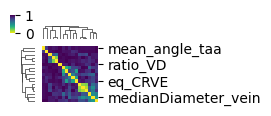

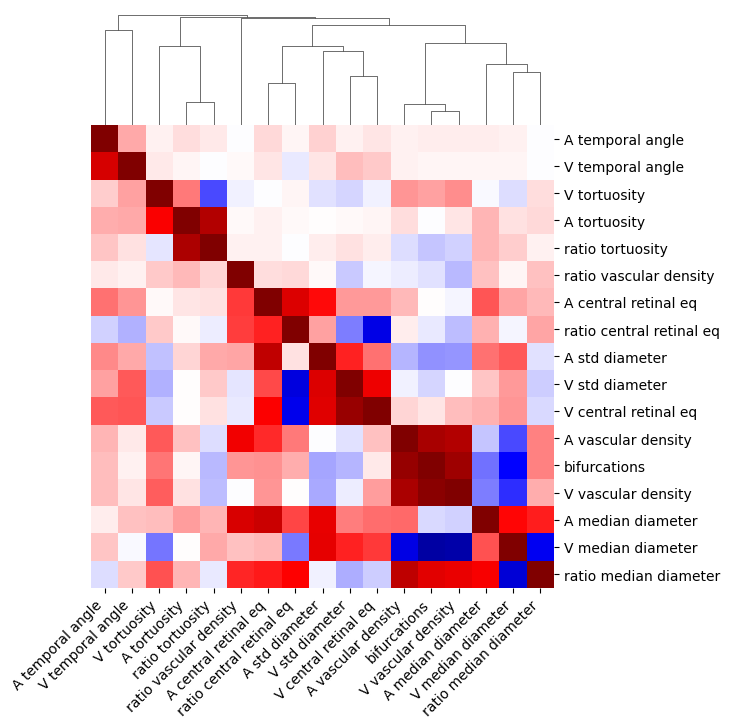

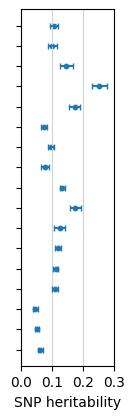

In [10]:
# clustermap figure

usedtraits = np.array(MAIN_LABELS)
names = np.array(MAIN_NAMES)

labels_with_n = [names[i] + " (" + str(round(traits[usedtraits].notna().sum().values[i]/1000)) + "k)" for i in range(0,len(usedtraits))]

# A: Clustermap

figsize=8

import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris

DF_corr = traits[usedtraits].corr()
DF_dism = 1 - np.abs(DF_corr) # pairwise distance: I define distance between two perfectly negatively correlated traits as 0

# pairwise distance metric: an easy proxy for "correlation distance": 1 - abs(corr)
# clustering method: average

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

# print cophenetic distance
print("Cophenetic distance:", hc.cophenet(linkage, sp.distance.squareform(DF_dism))[0])

# plotting just to receive order of labels, so I can set gcorr adequately
h = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(1,1), vmin=0, vmax=1, xticklabels=False)

reordered_ind = usedtraits[h.dendrogram_row.reordered_ind]

# saving order as indexes
np.asarray(h.dendrogram_row.reordered_ind).tofile(labels_order, sep=',')

# genetic correlations
for idx,i in enumerate(reordered_ind):
    for idx_j,j in enumerate(reordered_ind):
        if idx > idx_j:
            DF_corr.at[i,j] = df_corr.at[i,j]

# h = sns.clustermap(DF_corr, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('seismic'), figsize=(figsize,figsize), vmin=-1, cbar_kws={'label':"Correlation",'ticks':[-1,0,1]}, cbar_pos=(.05,0.4,.01,.3)) # cbar_pos=(0.8,.8,.01,.19)) # cbar_pos=(0,0.1,.01,.6)) #, vmin=-1, vmax=1)
# without colormap
h = sns.clustermap(DF_corr, row_linkage=linkage, col_linkage=linkage, cbar=False, cmap=cm.get_cmap('seismic'), figsize=(figsize,figsize), vmin=-1, vmax=1) # cbar_pos=(0.8,.8,.01,.19)) # cbar_pos=(0,0.1,.01,.6)) #, vmin=-1, vmax=1)
h.cax.set_visible(False)

ax = h.ax_heatmap

# ax.set_xlabel("Genotypic correlation \ Phenotypic correlation")
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
ax.tick_params(axis='x', rotation=90)
ax.set_yticklabels(names[h.dendrogram_row.reordered_ind])
# plt.setp(ax.yaxis.get_majorticklabels(), ha='center') # looks ugly
ax.set_xticklabels(names[h.dendrogram_row.reordered_ind], rotation=45, ha='right')
# plt.tight_layout()

plt.savefig(outfile1, bbox_inches='tight', transparent=True)
plt.savefig(outfile1.strip(".pdf")+".tiff", dpi = 1200, transparent=True)

# B: Heritability
# C: Disease & mortality

# reorder ldsc and cox according to phenotypic clustering
ldsc = ldsc_full.loc[reordered_ind]
cox = cox_full[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]

#### B: HERITABILITY

# fig, axs = plt.subplots(ncols=2, figsize=(4.5,figsize), gridspec_kw={'width_ratios': [40, 60]})

pos_cluster=h.ax_heatmap.get_position()
f,ax=plt.subplots(1,1,figsize=(1.2, pos_cluster.height * figsize))

# h_h2=sns.pointplot(data=ldsc,x=ldsc.index, y='h2',ax=axs[0],join=False, ci='h2_se')
ax.scatter(ldsc['h2'], ldsc.index, s=10)
ax.grid(axis='x', color='lightgray')
# h_h2 = axs[0].plot(ldsc['h2'], ldsc.index, 'o--')
ax.errorbar(ldsc['h2'], ldsc.index, xerr=ldsc['h2_se'], fmt='', linestyle='', elinewidth=1.5, capsize=2)
ax.invert_yaxis()
ax.set_yticklabels(names[h.dendrogram_row.reordered_ind])
ax.yaxis.set_ticklabels([])
# axs[0].grid(axis='y')
# axs[0].set_ylim((0,max(0.3,max(ldsc['h2']+max(ldsc['h2_se'])))))
# axs[0].set(xticklabels=[])
# axs[0].margins(x=0.005*40/figsize)
ax.set_xlabel("SNP heritability")
ax.set_xticks([0,.1,.2,.3])

plt.savefig(outfile2, bbox_inches='tight', transparent=True)
plt.savefig(outfile2.strip(".pdf")+".tiff", bbox_inches='tight', transparent=True)

In [11]:
# standardized difference between phenotypic and genotypic correlations

import scipy

phen_corr = DF_corr
gen_corr = df_corr[usedtraits].loc[usedtraits]

corr_dim = len(phen_corr)
triu_indices = np.triu_indices(corr_dim, k=1) # upper without diagonal

print( (np.mean(np.array(phen_corr)[triu_indices]) - np.mean(np.array(gen_corr)[triu_indices])) / np.mean([np.std(np.array(phen_corr)[triu_indices]), np.std(np.array(gen_corr)[triu_indices])]) )

print(scipy.stats.ttest_ind(np.array(phen_corr)[triu_indices], np.array(gen_corr)[triu_indices], alternative='less'))

print("Degrees of freedom:", len(np.array(phen_corr)[triu_indices]) + len(np.array(gen_corr)[triu_indices]) - 2)

-0.3383910770826452
Ttest_indResult(statistic=-2.7474247910894887, pvalue=0.003205461721945909)
Degrees of freedom: 270


In [12]:
# correlation between phenotypic and genetic correlation
# DF_corr: phenotypic correlation
# df_corr: genetic correlation

print("Correlation between phenotypic and genetic correlation")

from scipy.stats import pearsonr

corr_dim = len(phen_corr)

pearsonr(np.array(phen_corr)[np.triu_indices(corr_dim, k=1)], np.array(gen_corr)[np.triu_indices(corr_dim, k=1)])

Correlation between phenotypic and genetic correlation


PearsonRResult(statistic=0.8632849658210707, pvalue=1.2845191281428774e-41)

In [13]:
# # Permuting each trait separately (not what we needed here)

# usedtraits = np.array(MAIN_LABELS)
# main_traits = traits[usedtraits]
# main_traits.shape

# usedtraits = np.array(MAIN_LABELS)

# corrs = []
# for i in range(1000):
#     permuted_main_traits = pd.DataFrame(np.apply_along_axis(np.random.permutation, 0, main_traits))
#     corrs.append(np.mean(np.abs(permuted_main_traits.corr().values[np.triu_indices(len(usedtraits), k=1)])))

# plt.hist(corrs)

# # mean absolute correlation of main traits >> mean absolute correlation of random traits
# # as

# # permuted each trait individually to destroy correlation structure
# # computed mean abolute correlation of permuted traits in 1000 iterations
# # resulting distribution of mean abs corr shown above

# # below, observed mean absolute correlation
# # if observed larger than 95% of permuted, then p < 0.05
# # -> RESULT: we do have correlation structure

# np.mean(np.abs(main_traits.corr().values[np.triu_indices(len(usedtraits), k=1)]))

(array([  3.,  12.,  50., 131., 198., 271., 195., 105.,  26.,   9.]),
 array([-0.29004819, -0.23469581, -0.17934344, -0.12399106, -0.06863868,
        -0.01328631,  0.04206607,  0.09741845,  0.15277083,  0.2081232 ,
         0.26347558]),
 <BarContainer object of 10 artists>)

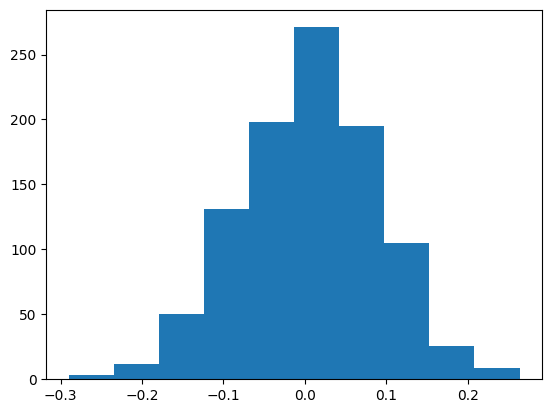

In [14]:
# Alternative: Permute gen_corr_triu (also not what was needed because it also destroys pairwise structure)

phen_corr_flat = np.array(phen_corr)[triu_indices]
gen_corr_flat = np.array(gen_corr)[triu_indices]

corrs = []
for i in range(1000):
    corrs.append(np.corrcoef(phen_corr_flat, np.random.permutation(gen_corr_flat))[0,1])

plt.hist(corrs)

# Result: p < 0.001

Max permutation correlation: 0.7043514327366603


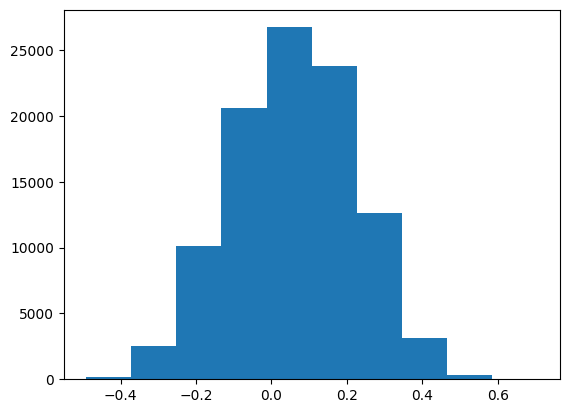

In [15]:
# Permuting labels of phenotypic correlations

phen_corr = DF_corr
gen_corr = df_corr[usedtraits].loc[usedtraits]

gen_corr_flat = np.array(gen_corr)[triu_indices]

corrs = []
for i in range(100000):

    # randomly shuffle labels
    phen_corr.columns = np.random.permutation(phen_corr.columns)

    # reorder to fit genetic correlation
    phen_corr = phen_corr[gen_corr.columns]

    phen_corr_flat = np.array(phen_corr)[triu_indices]

    corrs.append(np.corrcoef(phen_corr_flat, gen_corr_flat)[0,1])

plt.hist(corrs)
print("Max permutation correlation:", max(corrs))

In [16]:
# saving phenotypic and genetic correlations to csv

phen_corr.to_csv(RUN_PATH+"diseases_cov/"+ID+"_main_phenotypic_correlations.csv")
gen_corr.to_csv(RUN_PATH+"diseases_cov/"+ID+"_main_genetic_correlations.csv")

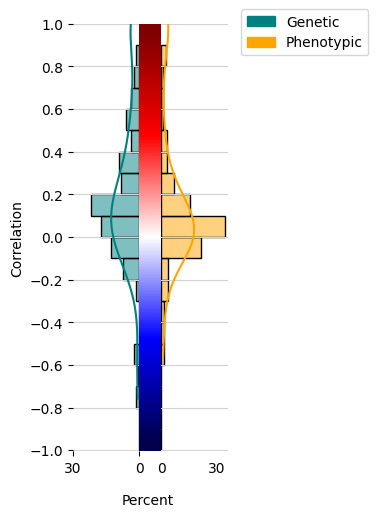

In [17]:
# colormap and pcorr gcorr histograms

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(2,pos_cluster.height * figsize *1.2), width_ratios=(0.45,0.15,0.45))

df_corr_full = df_corr.copy()
df_corr = df_corr[usedtraits].loc[usedtraits]
pltdf = pd.DataFrame({"Genetic correlation":np.array(df_corr)[np.triu_indices(n=len(df_corr))],"Phenotypic correlation":np.array(DF_corr)[np.triu_indices(n=len(DF_corr))]})
df_corr = df_corr_full.copy()

bins = np.arange(-1,1,.1)

for ax, column, color, invert in zip(axes.ravel(), [pltdf.columns[0],'cbar',pltdf.columns[1]], ['teal','','orange'],  [True,False,False]):
    if column != 'cbar':
        
        xlim=35.0
        
        # ax.hist(pltdf[column], bins=bins, color=color, orientation='horizontal')
        ax.grid(axis='y', color='lightgray')
        sns.histplot(y=pltdf[column], ax=ax, color=color, kde=True, bins=bins, stat='percent')
        ax.set_ylim((-1.005,1.0))
        ax.set_ylabel("")
        ax.set_xlabel("")
        # ax.legend([None,"Genetic"])
        # ax.set_xlim(( 0,xlim))
        ax.set_xticks((0,30))
        ax.set_yticks(np.linspace(-1,1,11))

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        # ax.hlines(0,0,xlim,color='black')

        if invert:
            ax.invert_xaxis()
        if not invert:
            ax.set_yticklabels([])
            ax.tick_params(width=0)
            ax.yaxis.set_label_position("right")


im=pd.DataFrame({'col':np.array(np.linspace(-1,1,20))})
# axes[1].imshow(im,aspect='auto', cmap='seismic')
axes[1].imshow(im,aspect='auto',interpolation="quadric", cmap='seismic')
axes[1].axis('off')
axes[1].invert_yaxis()

import matplotlib.patches as mpatches
teal_patch = mpatches.Patch(color='teal', label='Genetic')
orange_patch = mpatches.Patch(color='orange', label='Phenotypic')
axes[2].legend(handles=[teal_patch,orange_patch], bbox_to_anchor=(1.1, 1.05))
axes[0].set_ylabel("Correlation")

                
    # ax.grid()

fig.supxlabel('Percent', fontsize='medium')
plt.subplots_adjust(wspace=0)
# plt.tight_layout(hspace=0)

plt.savefig(outfile3, bbox_inches='tight', transparent=True)
plt.savefig(outfile3.strip(".pdf")+".tiff", bbox_inches='tight', transparent=True)
plt.savefig(outfile3.strip(".pdf")+".png", bbox_inches='tight', transparent=True)



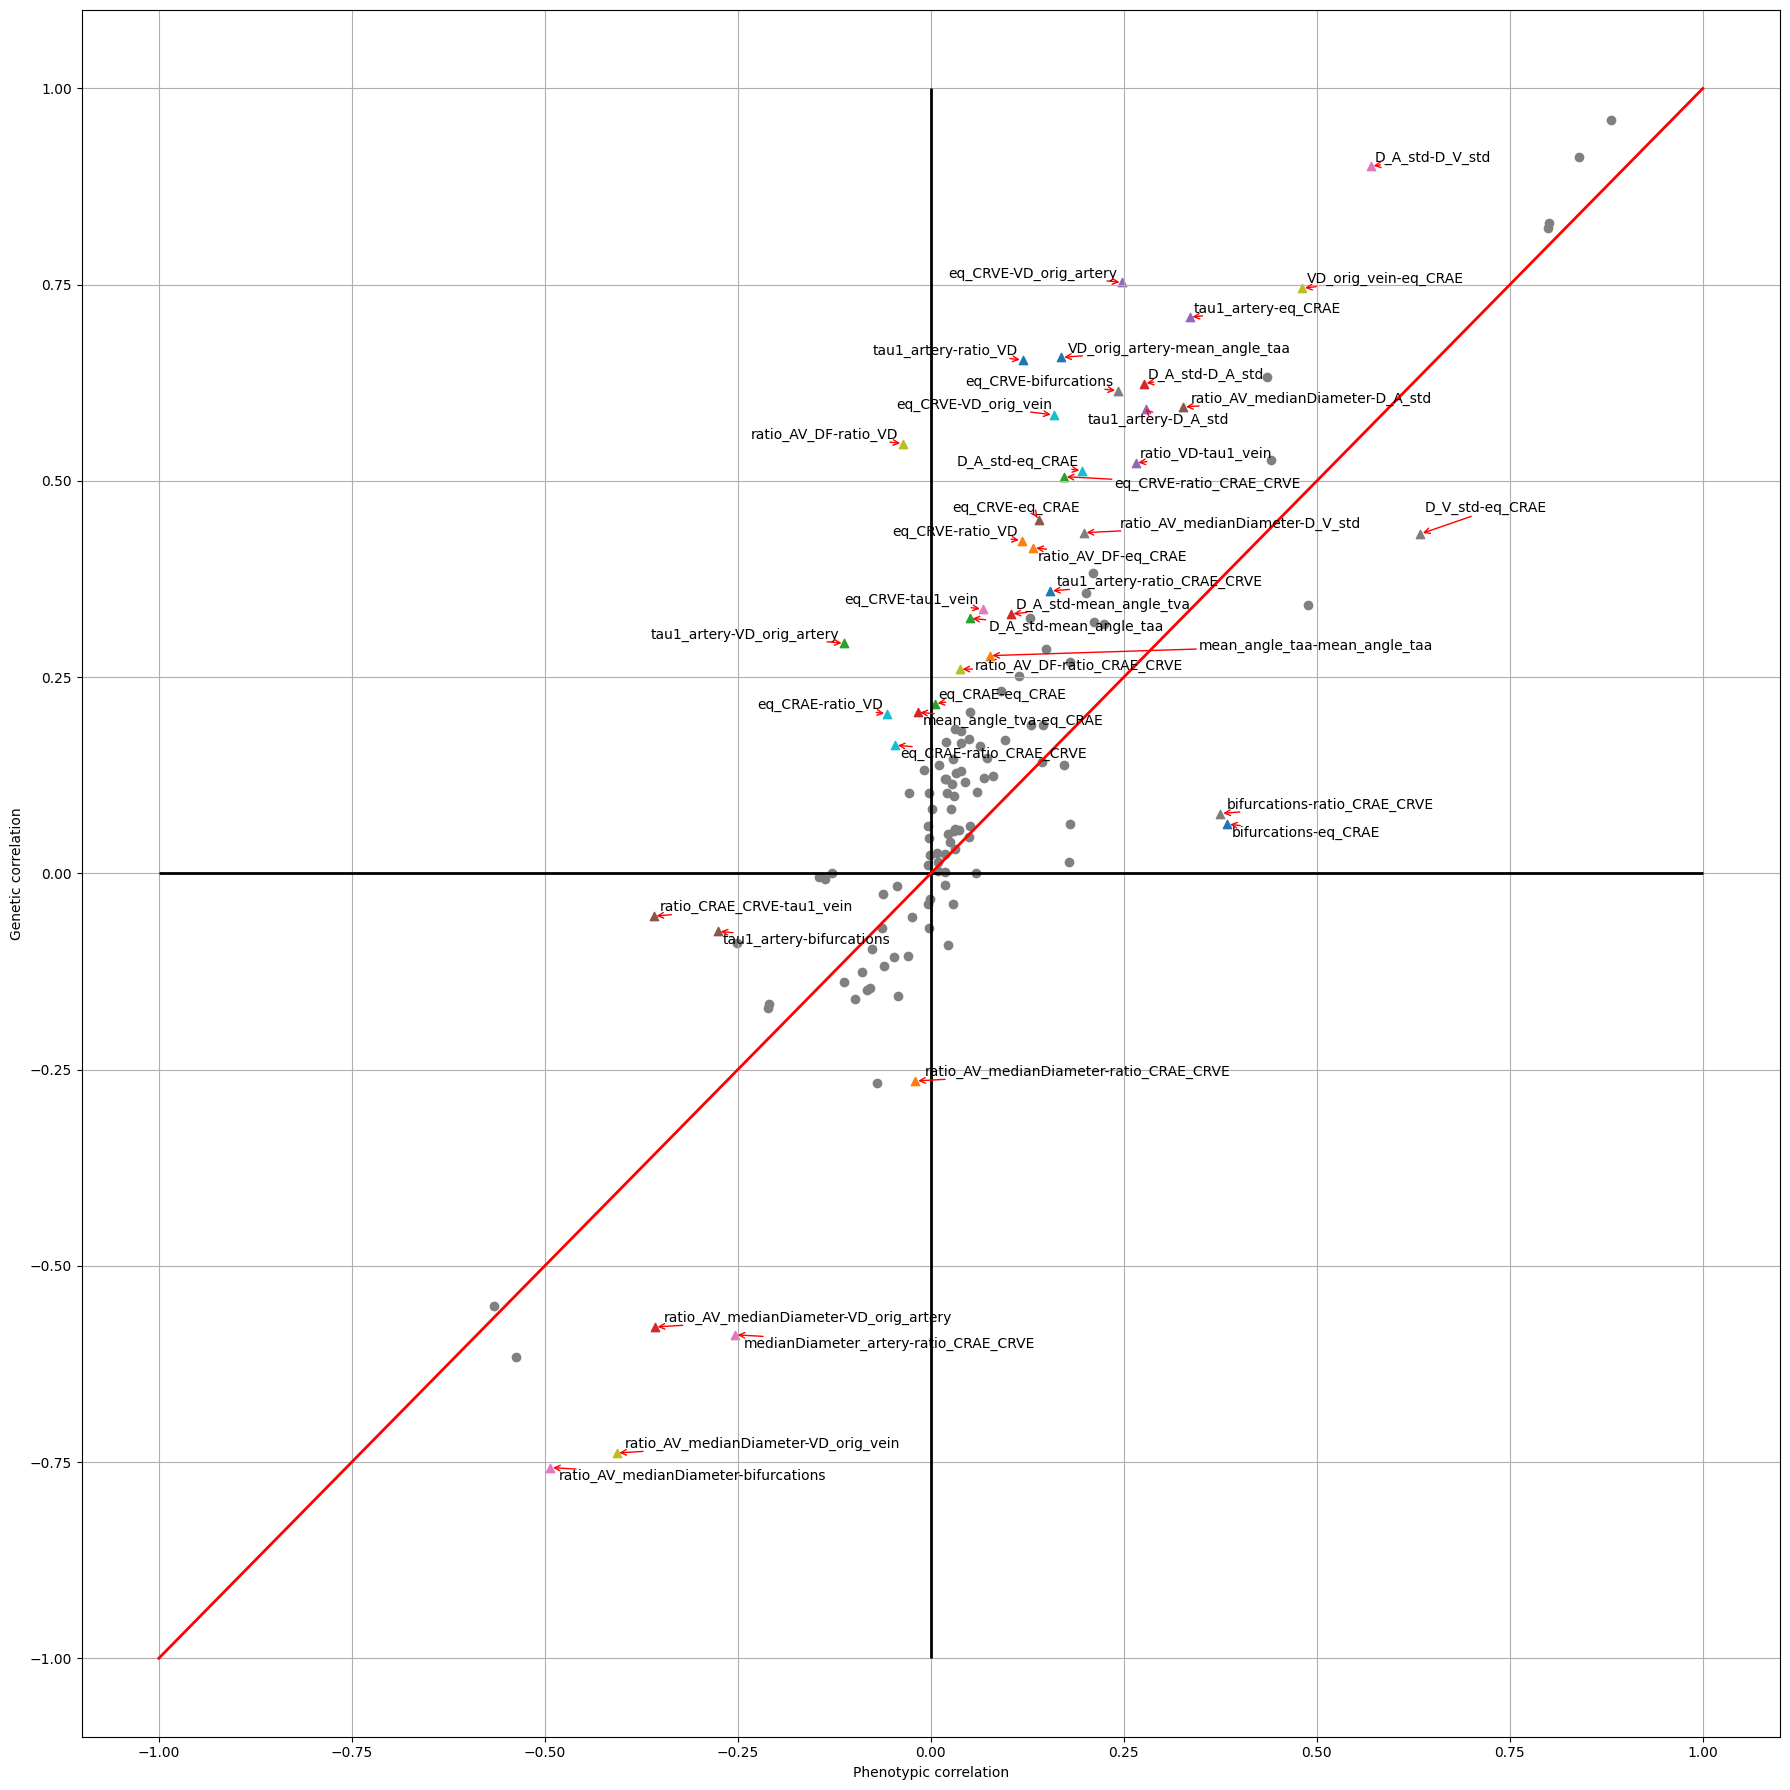

In [18]:
from adjustText import adjust_text

plt.figure(figsize=(18,18))
plt.hlines(0,-1,1, linewidth=2, color='black')
plt.vlines(0,-1,1, linewidth=2, color='black')

pcorr=[]
gcorr=[]
pair = []
for i in range(0,len(DF_corr)):
    for j in range(0,len(DF_corr)):
        if i < j:
            pcorr.append(DF_corr.iat[i,j])
            gcorr.append(DF_corr.iat[j,i])
            
            pair.append(DF_corr.columns[j] + "-" + DF_corr.index[i])


texts = []

for i in range(0,len(pcorr)):
    
    if (((pcorr[i]-gcorr[i]) > .2) | ((pcorr[i]-gcorr[i]) < -0.2)):
        plt.scatter(pcorr[i],gcorr[i], label=pair[i], marker='^')
        texts.append(plt.annotate(pair[i], (pcorr[i], gcorr[i]), ha='right'))
        
    else:
        plt.scatter(pcorr[i],gcorr[i], label=pair[i], color='gray')


adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.grid()
plt.plot([-1,1], [-1,1], color='red', linewidth=2)
plt.xlabel("Phenotypic correlation")
plt.ylabel("Genetic correlation")
plt.tight_layout()

plt.savefig(suppl_outfile_scatter, bbox_inches='tight')

# Supplementary

Cophenetic distance: 0.8940419172462313
[24, 25, 20, 5, 8, 1, 3, 4, 6, 7, 9, 0, 2, 26, 28, 30, 31, 27, 29, 11, 10, 12, 35, 18, 23, 16, 17, 19, 21, 22, 33, 32, 34, 14, 13, 15]


/tmp/ipykernel_37479/3638156272.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  h = sns.clustermap(DF_corr, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(1,1), vmin=0, vmax=1, xticklabels=False)
/SSD/home/michael/.local/lib/python3.8/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)
/tmp/ipykernel_37479/3638156272.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  h = sns.clustermap(DF_corr, row_linkage=linkage, col_linkage=linkage, cmap=cm.get

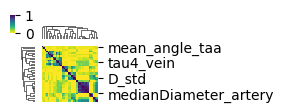

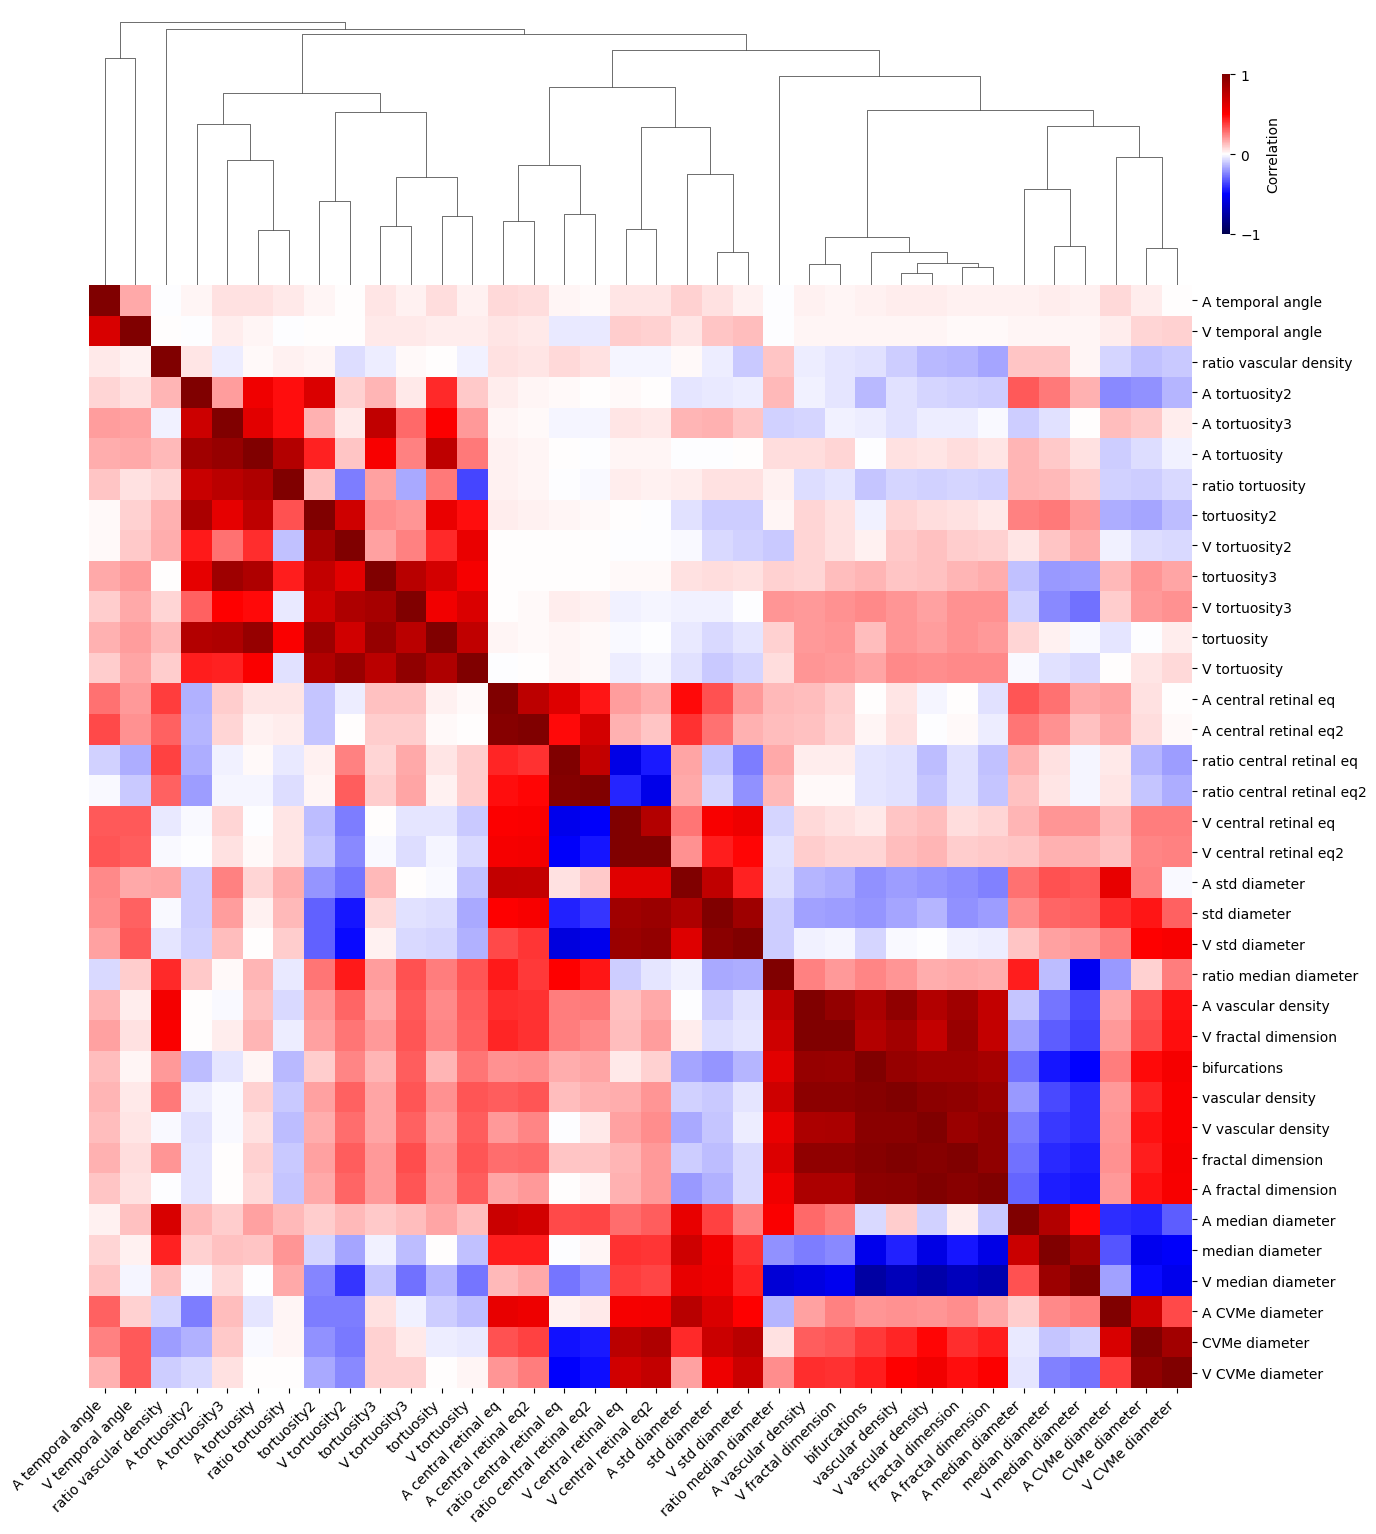

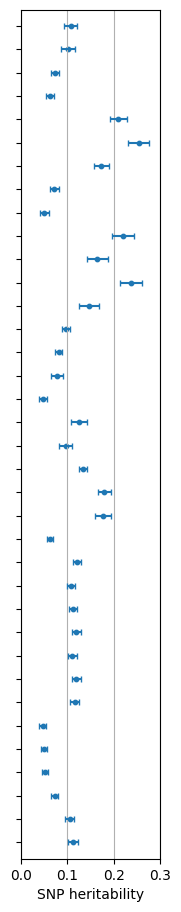

In [26]:
usedtraits = np.array(SUPPLEMENTARY_LABELS)
names = np.array(SUPPLEMENTARY_NAMES)
# usedtraits=supplementary_labels
# names=supplementary_names

# usedtraits=np.array(list(supplementary_labels))
# names=np.array(list(supplementary_names))

labels_with_n = [names[i] + " (" + str(round(traits[usedtraits].notna().sum().values[i]/1000)) + "k)" for i in range(0,len(usedtraits))]

# A: Clustermap

figsize=16

import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris

DF_corr = traits[usedtraits].corr()
DF_dism = 1 - np.abs(DF_corr)   # pairwise distance: I define distance between two perfectly negatively correlated traits as 0

DF_corr.to_csv(RUN_PATH+"diseases_cov/"+ID+"_supplementary_phenotypic_correlations.csv")
df_corr[usedtraits].loc[usedtraits].to_csv(RUN_PATH+"diseases_cov/"+ID+"_supplementary_genetic_correlations.csv")

# pairwise distance metric: an easy proxy for "correlation distance": 1 - abs(corr)
# clustering method: average

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

# print cophenetic distance
print("Cophenetic distance:", hc.cophenet(linkage, sp.distance.squareform(DF_dism))[0])

h = sns.clustermap(DF_corr, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(1,1), vmin=0, vmax=1, xticklabels=False)

# reordered index:
reordered_ind = usedtraits[h.dendrogram_row.reordered_ind]
print(h.dendrogram_row.reordered_ind)
np.asarray(h.dendrogram_row.reordered_ind).tofile(labels_order_suppl, sep=',')

# genetic correlations
for idx,i in enumerate(reordered_ind):
    for idx_j,j in enumerate(reordered_ind):
        if idx > idx_j:
            DF_corr.at[i,j] = df_corr.at[i,j]

h = sns.clustermap(DF_corr, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('seismic'), figsize=(figsize,figsize), cbar_kws={'label':"Correlation",'ticks':[-1,0,1]}, cbar_pos=(.89,0.85,.005,.1), vmin=-1) # cbar_pos=(0.8,.8,.01,.19)) # cbar_pos=(0,0.1,.01,.6)) #, vmin=-1, vmax=1)

ax = h.ax_heatmap

# ax.set_xlabel("Genotypic correlation \ Phenotypic correlation")
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
ax.tick_params(axis='x', rotation=90)
ax.set_yticklabels(names[h.dendrogram_row.reordered_ind])
# plt.setp(ax.yaxis.get_majorticklabels(), ha='center') # looks ugly
ax.set_xticklabels(names[h.dendrogram_row.reordered_ind], rotation=45, ha='right')
# plt.tight_layout()

plt.savefig(suppl_outfile1)
plt.savefig(suppl_outfile1.strip(".pdf")+".tiff", bbox_inches='tight')

# B: Heritability
# C: Disease & mortality

# reorder ldsc and cox according to phenotypic clustering
ldsc = ldsc_full.loc[reordered_ind]
cox = cox_full[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]

#### B: HERITABILITY

# fig, axs = plt.subplots(ncols=2, figsize=(4.5,figsize), gridspec_kw={'width_ratios': [40, 60]})

pos_cluster=h.ax_heatmap.get_position()
f,ax=plt.subplots(1,1,figsize=(1.8, pos_cluster.height * figsize))

# h_h2=sns.pointplot(data=ldsc,x=ldsc.index, y='h2',ax=axs[0],join=False, ci='h2_se')
ax.scatter(ldsc['h2'], ldsc.index, s=10)
ax.grid(axis='x')
# h_h2 = axs[0].plot(ldsc['h2'], ldsc.index, 'o--')
ax.errorbar(ldsc['h2'], ldsc.index, xerr=ldsc['h2_se'], fmt='', linestyle='', elinewidth=1.5, capsize=2)
ax.invert_yaxis()
ax.set_yticklabels(names[h.dendrogram_row.reordered_ind])
ax.yaxis.set_ticklabels([])
# axs[0].grid(axis='y')
# axs[0].set_ylim((0,max(0.3,max(ldsc['h2']+max(ldsc['h2_se'])))))
# axs[0].set(xticklabels=[])
# axs[0].margins(x=0.005*40/figsize)
ax.set_xlabel("SNP heritability")
ax.set_xticks([0,.1,.2,.3])
plt.margins(y=0.02)

# ax.tight_layout()

plt.savefig(suppl_outfile2, bbox_inches='tight')
plt.savefig(suppl_outfile2.strip(".pdf")+".tiff", bbox_inches='tight')

Cophenetic distance: 0.8530742262586626


/tmp/ipykernel_37479/1231537289.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  h = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(1,1), vmin=0, vmax=1, xticklabels=False)
/SSD/home/michael/.local/lib/python3.8/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)
/tmp/ipykernel_37479/1231537289.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  h = sns.clustermap(DF_corr, row_linkage=linkage, col_linkage=linkage, cmap=cm.get

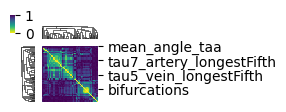

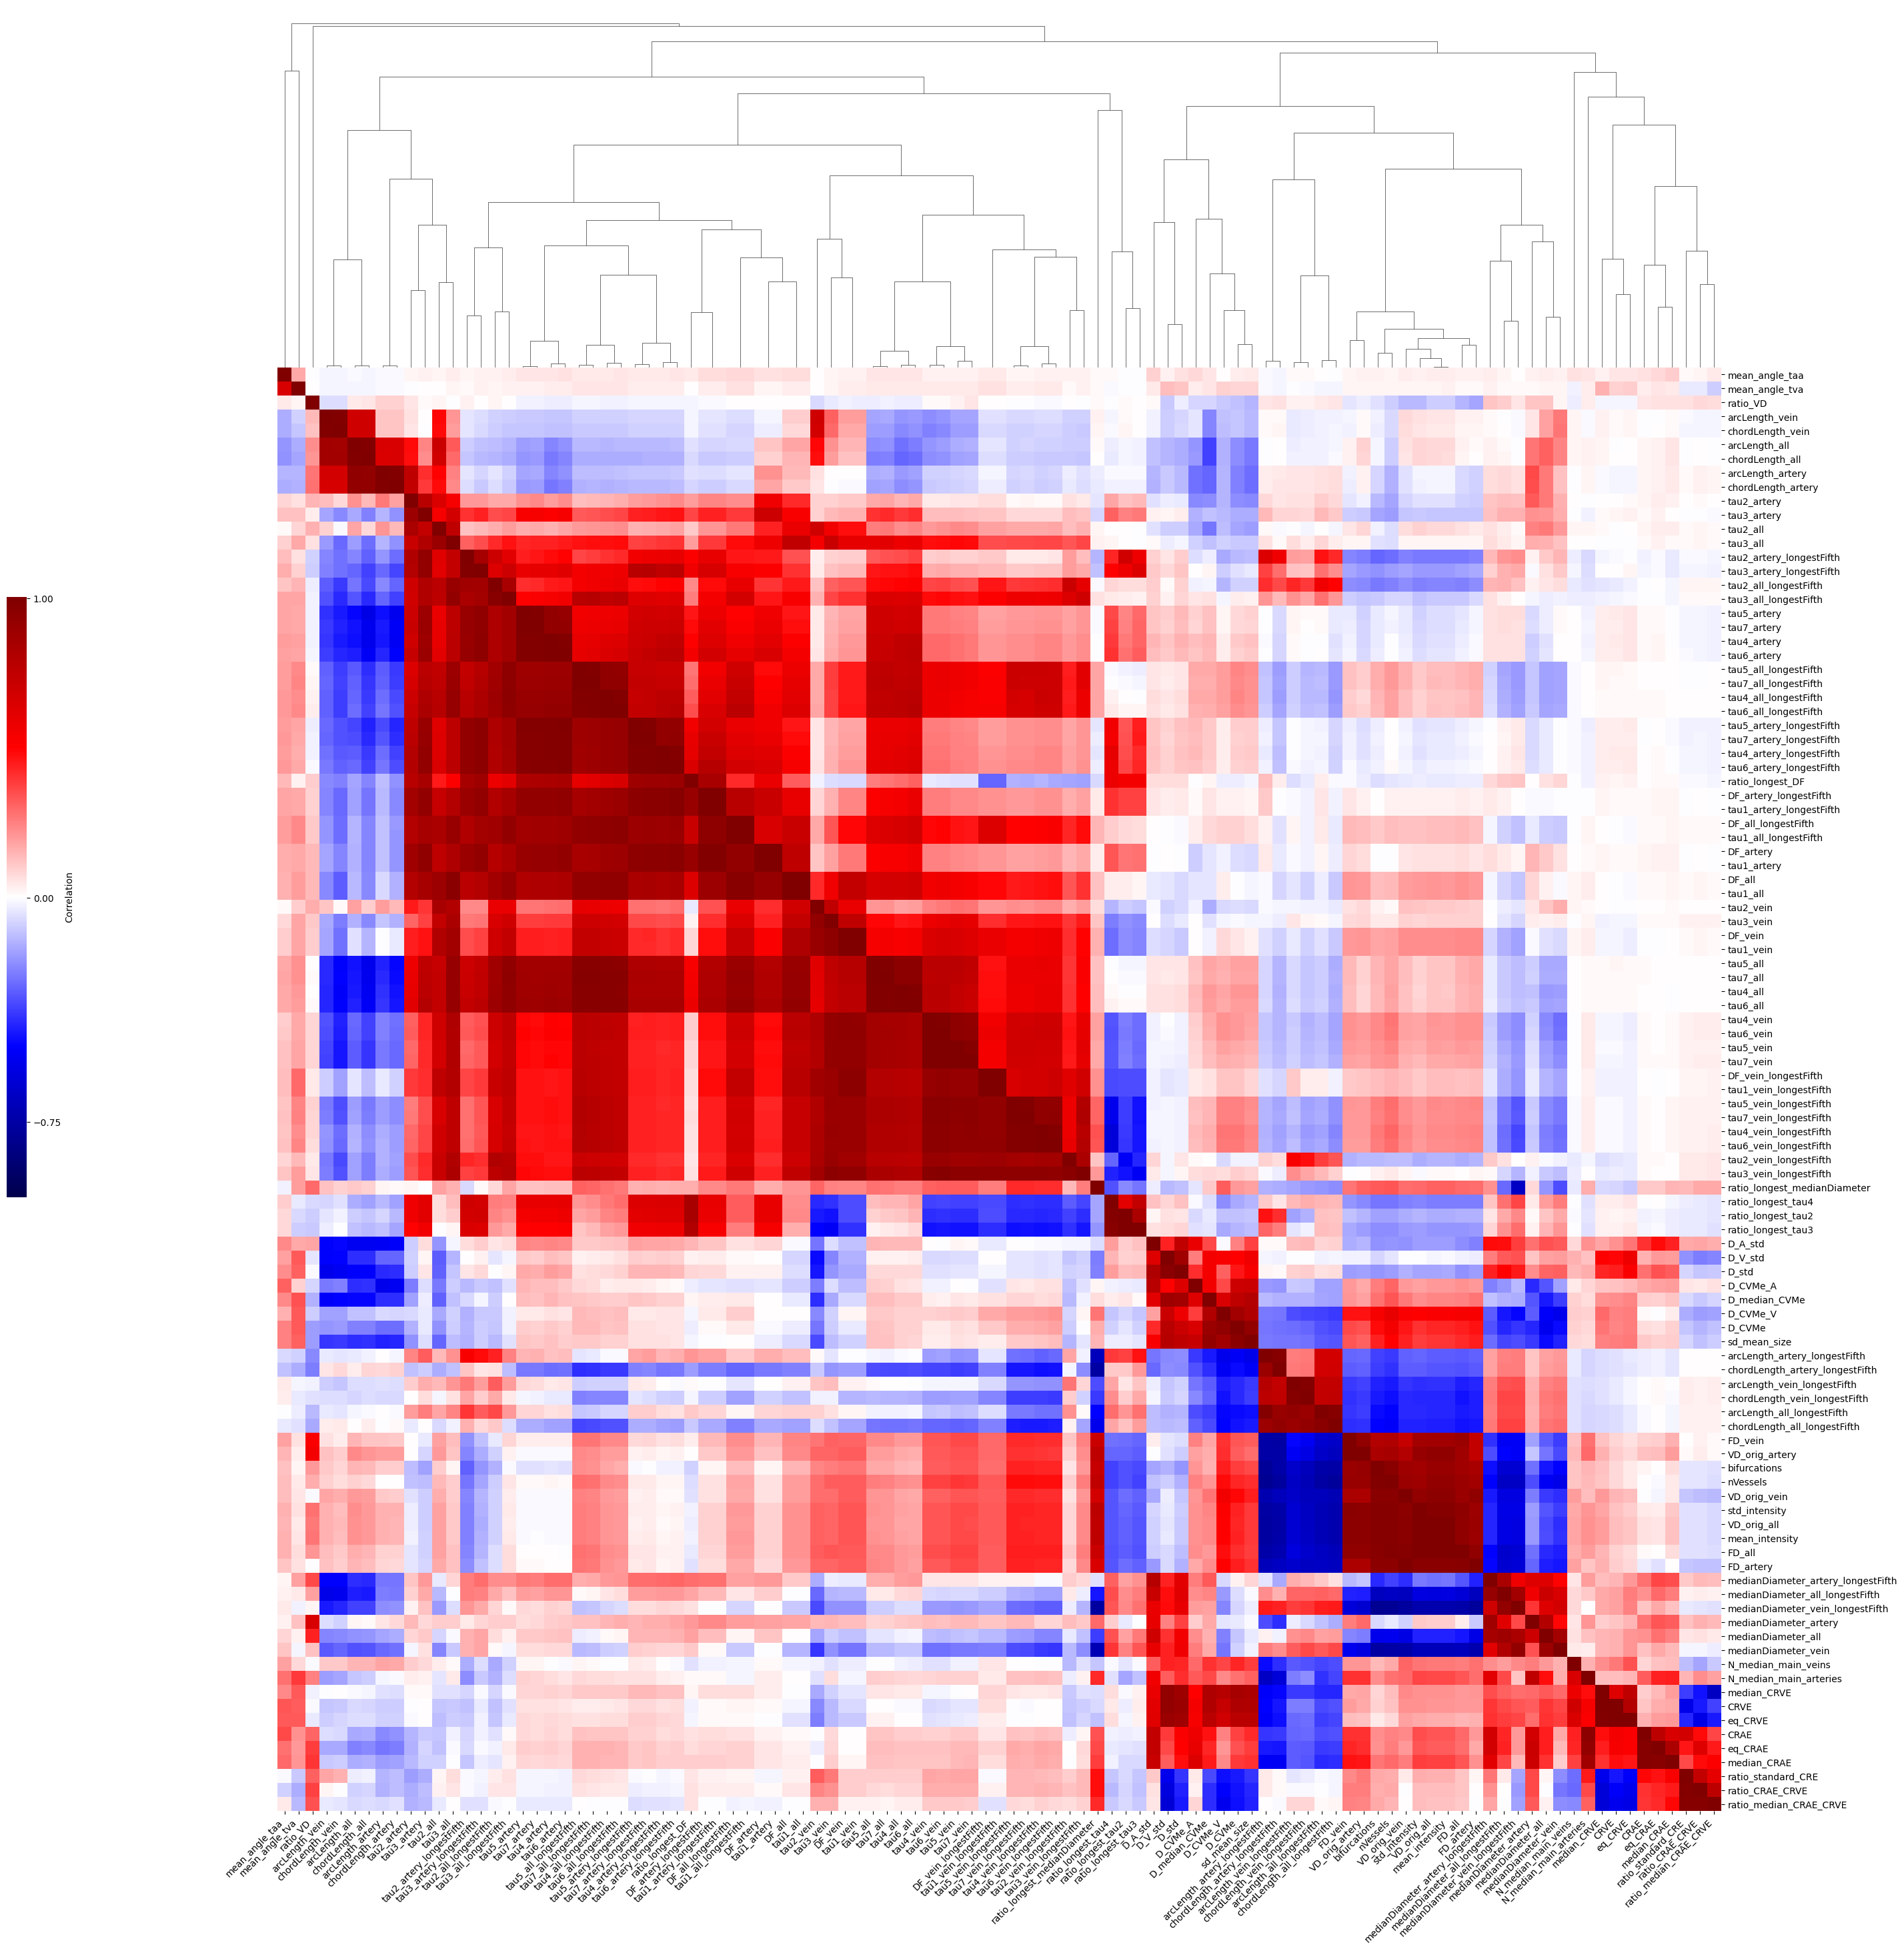

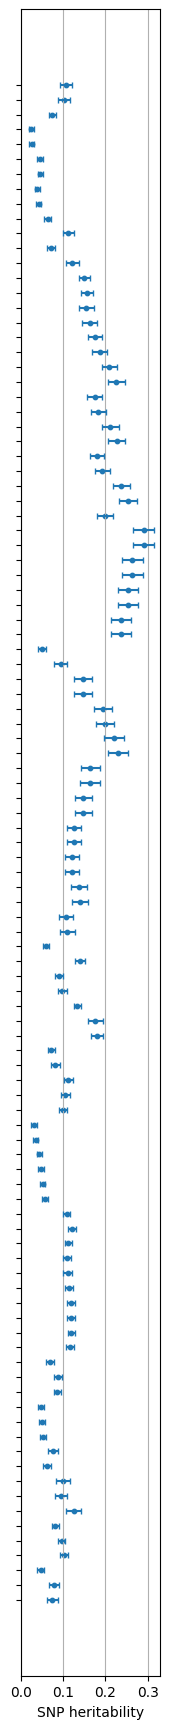

In [25]:
usedtraits = np.array([i for i in traits.columns if (('AV' not in i) & ('medianCenter' not in i))])
names = usedtraits

labels_with_n = [names[i] + " (" + str(round(traits[usedtraits].notna().sum().values[i]/1000)) + "k)" for i in range(0,len(usedtraits))]

# A: Clustermap

figsize=30

import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris

DF_corr = traits[usedtraits].corr()

DF_dism = 1 - np.abs(DF_corr)   # pairwise distance: I define distance between two perfectly negatively correlated traits as 0

# pairwise distance metric: an easy proxy for "correlation distance": 1 - abs(corr)
# clustering method: average

linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

# print cophenetic distance
print("Cophenetic distance:", hc.cophenet(linkage, sp.distance.squareform(DF_dism))[0])

# plotting just to receive order of labels, so I can set gcorr adequately
h = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(1,1), vmin=0, vmax=1, xticklabels=False)

reordered_ind = usedtraits[h.dendrogram_row.reordered_ind]

# genetic correlations
for idx,i in enumerate(reordered_ind):
    for idx_j,j in enumerate(reordered_ind):
        if idx > idx_j:
            DF_corr.at[i,j] = df_corr.at[i,j]

h = sns.clustermap(DF_corr, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('seismic'), figsize=(figsize,figsize), cbar_kws={'label':"Correlation",'ticks':[-.75,0,1]}, cbar_pos=(.05,0.4,.01,.3), vmin=-1) # cbar_pos=(0.8,.8,.01,.19)) # cbar_pos=(0,0.1,.01,.6)) #, vmin=-1, vmax=1)

ax = h.ax_heatmap

# ax.set_xlabel("Genotypic correlation \ Phenotypic correlation")
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
ax.tick_params(axis='x', rotation=90)
ax.set_yticklabels(names[h.dendrogram_row.reordered_ind])
# plt.setp(ax.yaxis.get_majorticklabels(), ha='center') # looks ugly
ax.set_xticklabels(names[h.dendrogram_row.reordered_ind], rotation=45, ha='right')
# plt.tight_layout()

# plt.savefig(outfile1, bbox_inches='tight')
# plt.savefig(outfile1.strip(".pdf")+".tiff", dpi = 1200)

# B: Heritability
# C: Disease & mortality

# reorder ldsc and cox according to phenotypic clustering
ldsc = ldsc_full.loc[reordered_ind]
cox = cox_full[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]

#### B: HERITABILITY

# fig, axs = plt.subplots(ncols=2, figsize=(4.5,figsize), gridspec_kw={'width_ratios': [40, 60]})

pos_cluster=h.ax_heatmap.get_position()
f,ax=plt.subplots(1,1,figsize=(1.8, pos_cluster.height * figsize))

# h_h2=sns.pointplot(data=ldsc,x=ldsc.index, y='h2',ax=axs[0],join=False, ci='h2_se')
ax.scatter(ldsc['h2'], ldsc.index, s=10)
ax.grid(axis='x')
# h_h2 = axs[0].plot(ldsc['h2'], ldsc.index, 'o--')
ax.errorbar(ldsc['h2'], ldsc.index, xerr=ldsc['h2_se'], fmt='', linestyle='', elinewidth=1.5, capsize=2)
ax.invert_yaxis()
ax.set_yticklabels(names[h.dendrogram_row.reordered_ind])
ax.yaxis.set_ticklabels([])
# axs[0].grid(axis='y')
# axs[0].set_ylim((0,max(0.3,max(ldsc['h2']+max(ldsc['h2_se'])))))
# axs[0].set(xticklabels=[])
# axs[0].margins(x=0.005*40/figsize)
ax.set_xlabel("SNP heritability")
ax.set_xticks([0,.1,.2,.3])

plt.savefig(outfile2, bbox_inches='tight')
plt.savefig(outfile2.strip(".pdf")+".tiff", bbox_inches='tight')

In [21]:
pairs = []
for i in cox_full.columns:
    if "longestFifth" in i and "AVS" not in i and 'medianC' not in i:
        pairs.append(i)
        pairs.append(i.replace("_longestFifth", ''))


<Axes: >

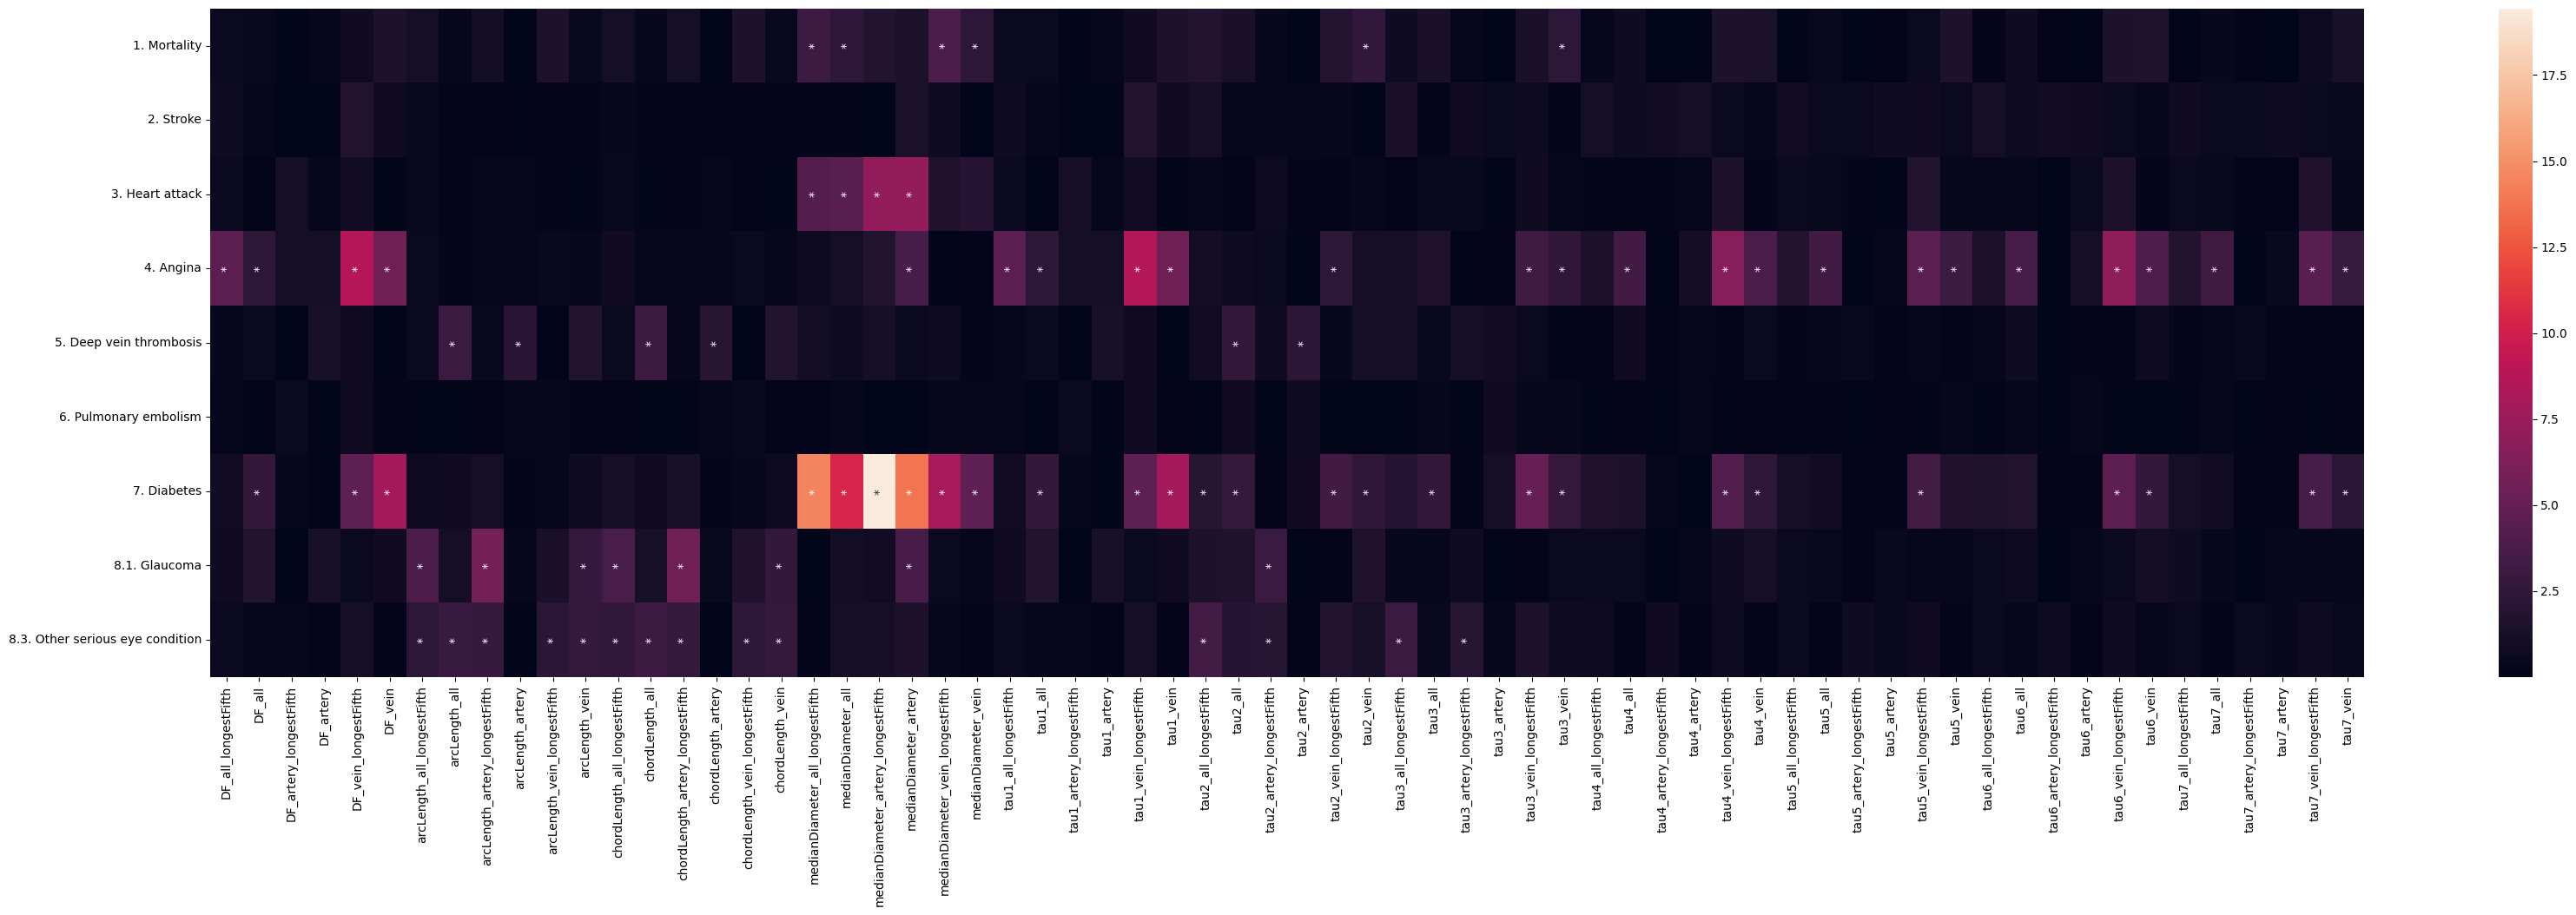

In [22]:
plt.figure(figsize=(40,10))
cox_melt = pd.melt(cox_full.reset_index(), id_vars='index')
cox_melt['rank'] = cox_melt['value'].rank(ascending=False)
cox_melt['bh_threshold'] = -np.log10(0.05 * cox_melt['rank'] / len(cox_melt))
cox_melt['significant'] = cox_melt['value'] > cox_melt['bh_threshold']
significant = cox_melt.pivot(columns='variable', index='index')['significant']

asterisks = significant.applymap(str)
asterisks = asterisks.replace('False', "")
asterisks = asterisks.replace('True', "*")

# asterisks = asterisks[traits[usedtraits].columns[h.dendrogram_row.reordered_ind]]

sns.heatmap(cox_full[pairs].drop('8.2. Cataract', axis=0), annot=asterisks[pairs].drop('8.2. Cataract', axis=0), fmt='', annot_kws={'rotation': 90}, )


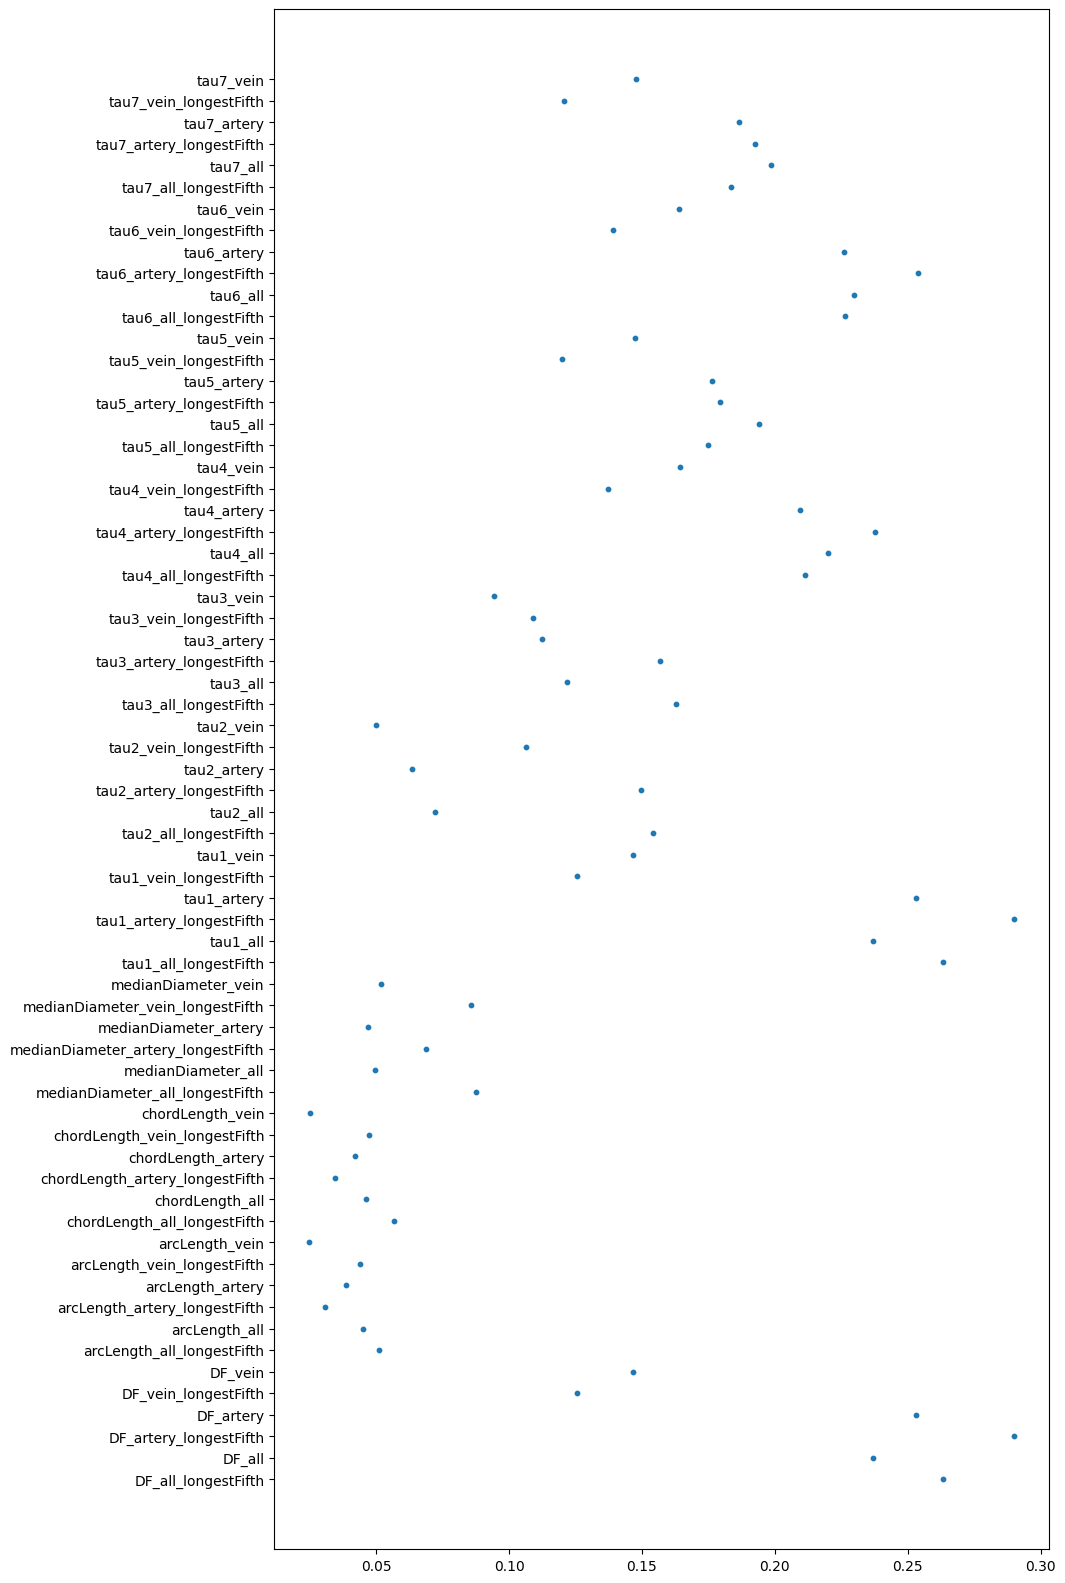

In [23]:
plt.figure(figsize=(10,20))
plt.scatter(ldsc['h2'].loc[pairs], pairs, s=10)
